# COMP5318 ASSIGNMENT 2: DATA ORGANIZATION AND CLEANING

**GROUP 144:**
- Aryan Bhatia : 490352056
- Mudit Malhotra : 490583269

**REFERENCES:**
- https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
- https://towardsdatascience.com/cleaning-preprocessing-text-data-for-sentiment-analysis-382a41f150d6
- https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Load-spaCy-model

## IMPORTING DATA & LIBRARIES

In [ ]:
import pandas as pd 
import re
import string 

# for removing emojis
from cleantext import clean

# for removing stopwords
import gensim

# for parallelization 
from joblib import Parallel, delayed

# for lemmatization
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# for feature extraction 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# for plotting 
import matplotlib.pyplot as plt

DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('tweets.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

### CLEANING DATA

**STEPS FOLLOWED FOR DATA CLEANING:**
- convert 4s to 1s (target) 
- drop duplicates
- lower case
- remove atsign
- remove urls 
- remove punctuations
- remove numbers 
- remove emojis
- remove stopwords
- remove 1 letter words 
- lemmatization using spacy

In [ ]:
# converting 4s to 1s
data = dataset[['text','target']]
data['target'] = data['target'].replace(4,1)

In [3]:
# drop duplicates 
data = data.drop_duplicates(subset='text')

In [4]:
# lower case 
def lower_case(text):
    return text.lower()

data['text'] = data['text'].apply(lambda text: lower_case(text))

In [5]:
# remove atsign
def remove_atsign(text):
    return " ".join([word for word in str(text).split() if '@' not in word])

data['text'] = data['text'].apply(lambda text: remove_atsign(text))

In [6]:
# remove urls
def remove_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', ' ', text)

data['text'] = data['text'].apply(lambda text: remove_url(text))

In [7]:
# remove punctuations 
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['text'] = data['text'].apply(lambda text: remove_punctuations(text))

In [8]:
# remove numbers
def remove_numbers(text):
    return " ".join([word for word in str(text).split() if not any(char.isdigit() for char in word)])

data['text'] = data['text'].apply(lambda text: remove_numbers(text))

In [9]:
# remove emojis
def remove_emojis(text):
    return clean(text, no_emoji=True)

data['text'] = data['text'].apply(lambda text: remove_emojis(text))

In [10]:
# remove stopwords
STOPWORDS = set(gensim.parsing.preprocessing.STOPWORDS)

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['text'] = data['text'].apply(lambda text: remove_stopwords(text))

When we performed lemmatization for the first time, our code ran for over 40 minutes and still didn't give an output. To make the process more efficient we decided to perform [parallel processing on spacy](https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Load-spaCy-model) to improve the performance. 

In [14]:
def lemmatize(doc):
    return " ".join([token.lemma_ for token in doc])

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer='processes')
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(data), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

data['text'] = preprocess_parallel(data['text'], chunksize=1000)

In [15]:
# remove 1 letter words 
def remove_1_letter(text):
    text = text.split()
    new_words = []
    for t in text:
        if len(t) > 1:
            new_words.append(t)
    return ' '.join(new_words)

data['text'] = data['text'].apply(lambda text: remove_1_letter(text))

## FEATURE EXTRACTION
After data has been cleaned we perform feature extraction using the TF-IDF algorithm (term frequency-inverse document frequency)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], 
                                                  random_state=30, stratify=data['target'], test_size=0.5)

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_test  = vectorizer.transform(X_test)

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

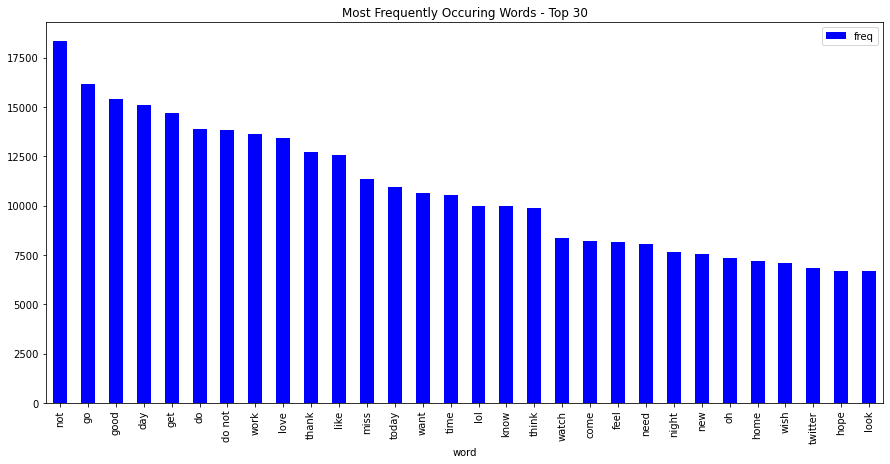

In [17]:
# most commonly occuring words 
sum_words = X_train.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

## STORE DATASET

In [18]:
%store X_train
%store X_test
%store y_train
%store y_test

Stored 'X_train' (csr_matrix)
Stored 'X_test' (csr_matrix)
Stored 'y_train' (Series)
Stored 'y_test' (Series)
